# DBA4811 AY20/21 Semester 2 Group Project

Gan Shi Yong, Thomas  |  Owyong Zi Xin  |  Rupanshi Chugh  |  Zhang Feimo

**Table of Contents**

(1) [Introduction](#section1)
* [Data Source and Description](#section1_1)
* [Project Objectives](#section1_2)

(2) [Exploratory Data Anaylsis](#section2)
* [Loading and Examining Data](#section2_1)
* [Basic Preprocessing](#section2_2)
* [Variables Overview](#section2_3)
* [Month-level Aggregation](#section2_4)
* [Hour-level Aggregation](#section2_5)
    * [User Type Analysis](#section2_5_1)
    * [Working Day Analysis](#section2_5_2)
    * [Day of Week Analysis](#section2_5_3)
    * [Weather Situation Analysis](#section2_5_4)
    * [Season Analysis](#section2_5_5)

(3) [Regression Modelling](#section3)
* [Feature Engineering](#section3_1)
    * [Dependent y-variable - Bike Utilisation](#section3_1_1)
    * [Correlation Analysis](#section3_1_2)
    * [Categorical Dummy Variables](#section3_1_3)
* [Model Preparation](#section3_2)
    * [Train-test Split](#section3_2_1)
    * [Cross-Validation Performance Evaluation Function](#section3_2_2)
    * [Variable Importance Visualisation Function](#section3_2_3)
* [OLS Linear Regression](#section3_3)
    * [Evaluating y-variable Transformations](#section3_3_1)
    * [L1 Regularisation for Variable Selection](#section3_3_2)
    * [Comparing OLS Regularised Models](#section3_3_3)
* [Decision Tree](#section3_4)
    * [Hyperparameter Tuning via Grid Search](#section3_4_1)
    * [Selecting Top Features for Pruned Tree](#section3_4_2)
* [Random Forest](#section3_5)
    * [Hyperparameter Tuning via Randomised Search](#section3_5_1)
    * [Selecting Top Features](#section3_5_2)   
* [Gradient Boost](#section3_6)  
    * [Hyperparameter Tuning via Randomised Search](#section3_6_1)
    * [Selecting Top Features](#section3_6_2)   
* [Summary of Models](#section3_7)
    * [In-sample CV Performance](#section3_7_1)
    * [Out-of-sample Performance](#section3_7_2)
  
(4) [Time Series Analysis](#section4)
* [Data Preparation for Time Series](#section4_1)
* [ARIMA Modelling](#section4_2)
     * [In-sample Performance Analysis](#section4_2_1)
     * [Out-of-sample Performance Analysis](#section4_2_2)

# Introduction <a class="anchor" id="section1"></a>

## Data Source and Description <a class="anchor" id="section1_1"></a>

[Bike sharing systems](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset) allow users to easily rent a bike from a particular starting station and return it to any other stations. This business model is evaluated to be very promising, especially in metropolitan cities with heavy traffic, since it provides an convenient, cheap, and environmentally-friendly mode of transportation. 

As bike sharing systems are typically hosted on platform i.e. users utilises some form of app to access this service, data can be easily collected and monitored. Real-time analysis and optimisation can be carried out to track bike demand across different times and days (measured by how many bikes are rented in that particular timeframe) to identify areas of improvement for boosting revenue. Essentially, bike sharing system works as a virtual sensor network that can be used to sense mobility in the city.

## Project Objectives <a class="anchor" id="section1_2"></a>

**Operational Sustainability**  
  
We would like to analyse the data to determine when is the most optimal timing to service and maintain the bikes for each month, during regular office hours of 9 am to 6 pm. This can be done by performing *exploratory data analysis*, whereby the bike usage patterns will be analysed based on the time period (hour) and day of week (Monday, Tuesday, and so forth).

**Boosting Revenue**  
  
Similar to the above analysis, we want to better understand the distribution of bike demand and see how we are able to adjust or "spread" the demand out more evenly across different timings of the day. This is necessary as the number of bikes is fixed and non-utilisation at point of time is simply wasting money. Again, *exploratory data analysis* will be conducted to get an aggregated-level sensing of demand distribution, and with that, we will propose a suitable discount pricing scheme. 

**Forecasting and Planning**  
  
Besides descriptive analytics, where we look into the past trends to identify key areas of improvement, we would also like to be able to predict bike utilisation based on the prevailing factors and trends observed. This will greatly facilitate operational needs such as the planning of maintenance schedule and pricing schemes, thereby allowing the company to get a better sensing. 

Two approaches will be taken to achieve this objective, namely regression methods such as Linear Regression and Decision Trees, and time series methods such as ARIMA. After building these models, their performance (how well can they predict bike usage) will be assessed and evaluated against one another. We will then propose the best model to be adopted based on the prediction accuracy (for regression analysis, lowest RMSE or highest R2 value) and intepretability (ease of understanding the prediction).

# Exploratory Data Analysis <a class="anchor" id="section2"></a>

We would like to credit our exploratory data analysis and findings to this [blog](https://anindya-saha.github.io/blog/machine-learning-with-python/kaggle-bike-sharing-demand/kaggle-bike-sharing-demand.html) which gave us ideas on which variables to particularly look out for.

## Load and Examine Data <a class="anchor" id="section2_1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_excel('Bike_Sharing2.xls')

In [4]:
# Remove S_No and website link columns
# Remove Date columns since relevant information has been extracted
data.drop(['S_No', 'https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset', 'Date'], axis = 1, inplace = True)

In [5]:
data.head()

,index,Time,season,yr,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
0,1.0,2011-01-01 00:00:00,1,0,1,1,0,0,6,0,1.0,0.24,0.2879,0.81,0.0,3.0,13.0
1,2.0,2011-01-01 01:00:00,1,0,1,1,1,0,6,0,1.0,0.22,0.2727,0.80,0.0,8.0,32.0
2,3.0,2011-01-01 02:00:00,1,0,1,1,2,0,6,0,1.0,0.22,0.2727,0.80,0.0,5.0,27.0
3,4.0,2011-01-01 03:00:00,1,0,1,1,3,0,6,0,1.0,0.24,0.2879,0.75,0.0,3.0,10.0
4,5.0,2011-01-01 04:00:00,1,0,1,1,4,0,6,0,1.0,0.24,0.2879,0.75,0.0,0.0,1.0


In [6]:
data.shape

(17544, 17)

In [7]:
data.describe()

,index,season,yr,mnth,day,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
count,17379.0000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17544.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.496580,0.500684,6.519836,15.738714,11.500000,0.028728,2.997264,0.683995,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869
std,5017.0295,1.110079,0.500014,3.449649,8.804172,6.922384,0.167045,2.003472,0.464928,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286
min,1.0000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4345.5000,2.000000,0.000000,4.000000,8.000000,5.750000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000
50%,8690.0000,3.000000,1.000000,7.000000,16.000000,11.500000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000
75%,13034.5000,3.000000,1.000000,10.000000,23.000000,17.250000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000
max,17379.0000,4.000000,1.000000,12.000000,31.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000


## Basic Preprocessing <a class="anchor" id="section2_2"></a>

In [8]:
data_1 = data.copy()

In [9]:
# Function for re-naming season column
def change_season(x):
    
    if x == 1:
        return 'spring'
    elif x == 2:
        return 'summer'
    elif x == 3:
        return 'fall'
    else:
        return 'winter'

In [10]:
# Function for re-naming weekday column
def change_weekday(x):
    
    if x == 0:
        return 'Sunday'
    elif x == 1:
        return 'Monday'
    elif x == 2:
        return 'Tuesday'
    elif x == 3:
        return 'Wednesday'
    elif x == 4:
        return 'Thursday'
    elif x == 5:
        return 'Friday'
    else:
        return 'Saturday'

In [11]:
# Function for re-naming weathersit column
def change_weathersit(x):
    
    if x == 1:
        return 'clear'
    elif x == 2:
        return 'mist'
    elif x == 3:
        return 'light snow'
    else:
        return 'heavy rain'

In [12]:
# Apply re-naming function
data_1['season'] = data_1['season'].apply(change_season)
data_1['weekday'] = data_1['weekday'].apply(change_weekday)
data_1['weathersit'] = data_1['weathersit'].apply(change_weathersit)

In [13]:
# Change column names
data_1.rename(columns = {'yr': 'year_2012', 
                         'mnth': 'month', 
                         'hr': 'hour'}, inplace = True)

## Variables Overview <a class="anchor" id="section2_3"></a>

In [14]:
%matplotlib inline
sns.set_palette('pastel')
plt.rcParams['figure.figsize'] = [10, 6]

In [15]:
def plot_histogram(x, color, label, i, j):
    axs[i, j].hist(x, color = color, edgecolor = 'black')
    axs[i, j].set_title('Histogram of ' + label)

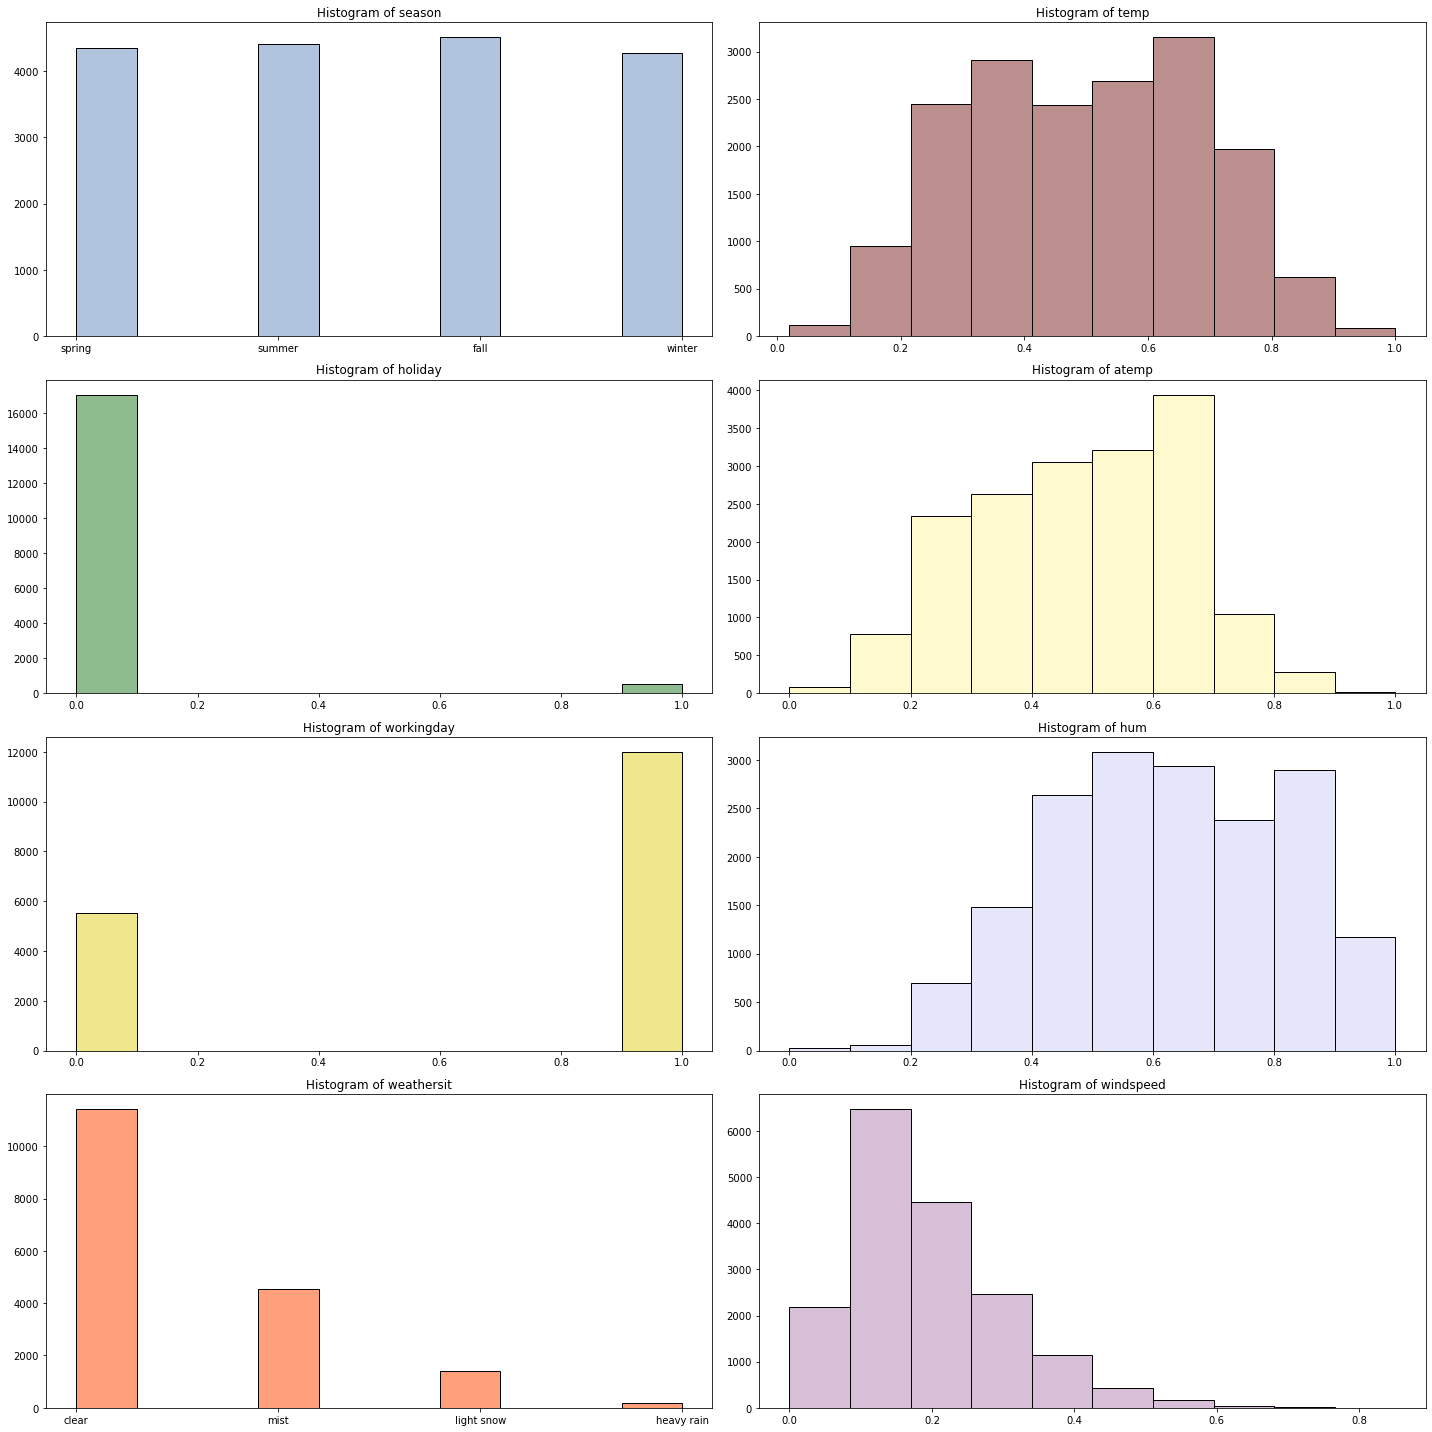

In [16]:
variables_1 = ['season', 'holiday', 'workingday', 'weathersit'] 
variables_2 = ['temp', 'atemp', 'hum', 'windspeed']

color_1 = ['lightsteelblue', 'darkseagreen', 'khaki', 'lightsalmon']
color_2 = ['rosybrown', 'lemonchiffon', 'lavender', 'thistle']

fig, axs = plt.subplots(4, 2, figsize = (20, 20))

for i in range(0, 4):
    plot_histogram(data_1[variables_1[i]], color_1[i], variables_1[i], i, 0)
    plot_histogram(data_1[variables_2[i]], color_2[i], variables_2[i], i, 1)

plt.tight_layout()
plt.show()

## Month-level Aggregation <a class="anchor" id="section2_4"></a>

In [17]:
# Group variables based on year and month
data_month = data_1[['year_2012', 'month', 'temp', 'atemp', 'hum', 'windspeed', 'casual', 'registered']]\
             .groupby(['year_2012', 'month'])\
             .mean()

# Convert weather conditions variables back to their original values
data_month['temp']  = data_month['temp']  * 41
data_month['atemp'] = data_month['atemp'] * 50
data_month['hum']   = data_month['hum']   * 100
data_month['windspeed'] = data_month['windspeed'] * 67

data_month

temp      atemp        hum  windspeed     casual  \
year_2012 month                                                          
0         1       8.093924  10.187892  57.405523  13.231497   4.466570   
          2      11.642989  14.286479  55.970724  15.373238   9.617874   
          3      13.580548  16.243959  57.005479  15.559098  17.569863   
          4      19.311627  22.831203  66.821975  16.355017  31.079277   
          5      23.666478  27.540679  71.336022  12.145371  41.733871   
          6      28.416417  32.327972  59.325000  11.939093  42.516667   
          7      31.101586  35.533011  58.966398  11.501721  48.994624   
          8      28.927715  32.782476  62.562244  12.603497  39.455540   
          9      25.129512  28.429554  78.382148  10.234722  37.022315   
          10     19.265034  22.935101  70.654105  11.764830  33.946164   
          11     16.490097  19.959812  67.521558  12.126991  21.688456   
          12     13.336896  16.501613  64.952767  11.242012  11.400810   
1         1      11.275277  13.747686  58.731444  14.532092  12.103914   
          2      12.932775  15.729321  57.424855  13.621739  12.602601   
          3      18.430686  21.935720  60.771198  14.269539  42.554509   
          4      19.230028  22.879791  50.789694  15.043385  53.559889   
          5      25.106989  29.025517  66.455645  12.375134  59.455645   
          6      27.679556  31.496597  55.836111  12.907178  60.130556   
          7      30.846989  34.876378  60.608871  10.750168  56.055108   
          8      29.183844  32.376720  64.862903  10.392763  58.060484   
          9      25.423417  29.502653  64.537500  11.986356  60.802778   
          10     20.718898  24.493757  67.159605  11.260164  48.782486   
          11     13.782396  16.771866  57.480501  12.497618  29.260446   
          12     13.244879  16.128228  68.268194  12.418152  17.850404   

                 registered  
year_2012 month              
0         1       51.040698  
          2       64.673344  
          3       70.163014  
          4      100.867872  
          5      140.821237  
          6      156.805556  
          7      140.979839  
          8      147.536252  
          9      140.687587  
          10     132.286676  
          11     120.407510  
          12     106.443995  
1         1      118.454791  
          2      136.439306  
          3      179.349933  
          4      189.091922  
          5      203.803763  
          6      221.577778  
          7      217.610215  
          8      230.250000  
          9      242.770833  
          10     232.066384  
          11     183.363510  
          12     148.878706

<AxesSubplot:xlabel='year_2012,month'>

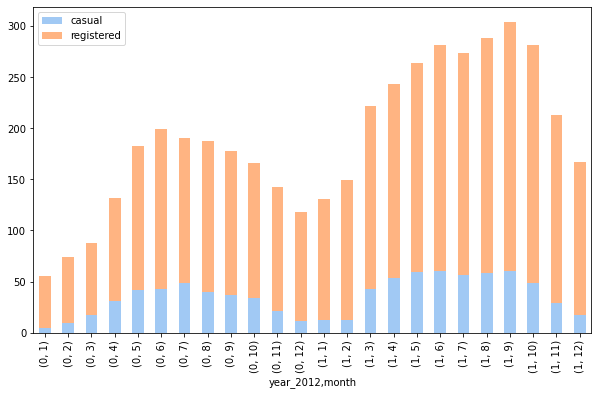

In [18]:
# Visualise demand (number of users) distribution
data_month[['casual', 'registered']].plot.bar(stacked = True)

<AxesSubplot:xlabel='year_2012,month'>

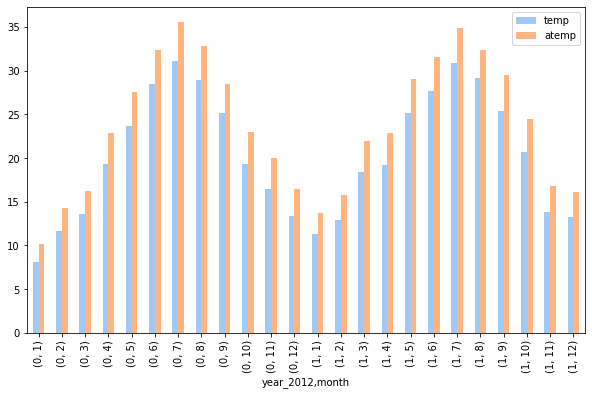

In [19]:
# Visualise temperature distribution
data_month[['temp', 'atemp']].plot.bar()

<AxesSubplot:xlabel='year_2012,month'>

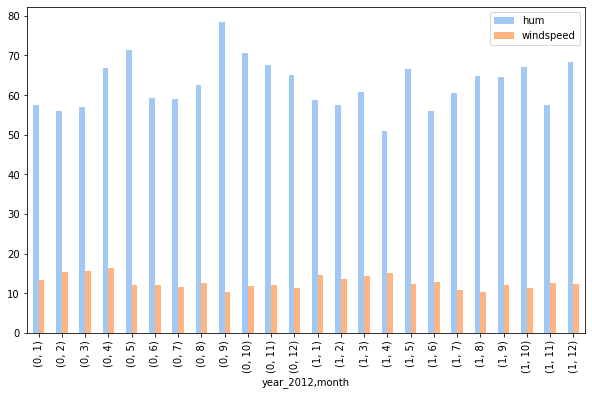

In [20]:
# Visualise humidity and windspeed distribution
data_month[['hum', 'windspeed']].plot.bar()

## Hour-level Aggregation <a class="anchor" id="section2_5"></a>

### User Type Analysis  <a class="anchor" id="section2_5_1"></a>

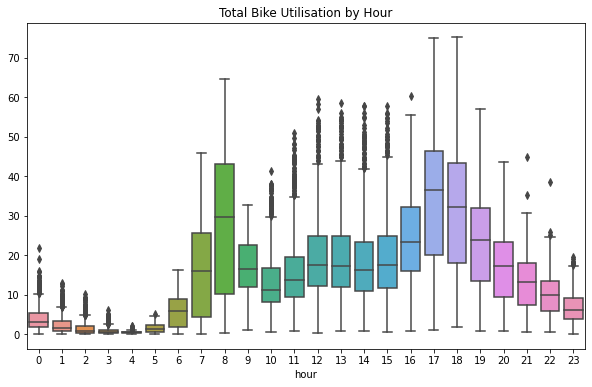

In [21]:
# Total bike utilisation by all users, assuming a constant total of 1300 bikes
sns.boxplot(x = data_1['hour'], 
            y = (data_1['casual'] + data_1['registered'])/ 13)\
   .set_title('Total Bike Utilisation by Hour')

plt.show()

**High** demand is observed between 0700 to 1900, peaking at 0800 (morning work crowd) and 1800 hours (after work crowd).  
**Very low** demand from 0000 to 0600 hours.

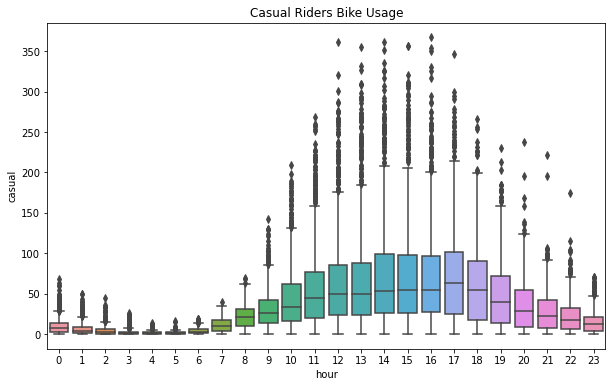

In [22]:
# Bike usage by casual users
sns.boxplot(x = data_1['hour'], y = data_1['casual']).set_title('Casual Riders Bike Usage')
plt.show()

Casual usage behaviour is observed to be different from the registered users; demand doesn't "peak" but remains rather constant throughout the day. 

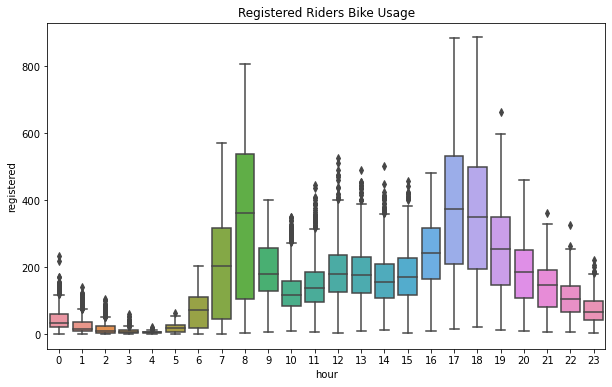

In [23]:
# Bike usage by registered users
sns.boxplot(x = data_1['hour'], y = data_1['registered']).set_title('Registered Riders Bike Usage')
plt.show()

In [24]:
user_type  = pd.melt(data_1[['hour', 'casual', 'registered']], 
                     id_vars = ['hour'], 
                     value_vars = ['casual', 'registered'], 
                     var_name = 'user_type', 
                     value_name = 'usage')

usage_type = pd.DataFrame({'mean_usage': user_type.groupby(['hour', 'user_type'])['usage'].mean()}).reset_index()
usage_type.head(10)

,hour,user_type,mean_usage
0,0,casual,10.158402
1,0,registered,43.739669
2,1,casual,6.504144
3,1,registered,26.871547
4,2,casual,4.772028
5,2,registered,18.097902
6,3,casual,2.715925
7,3,registered,9.011478
8,4,casual,1.253945
9,4,registered,5.098996


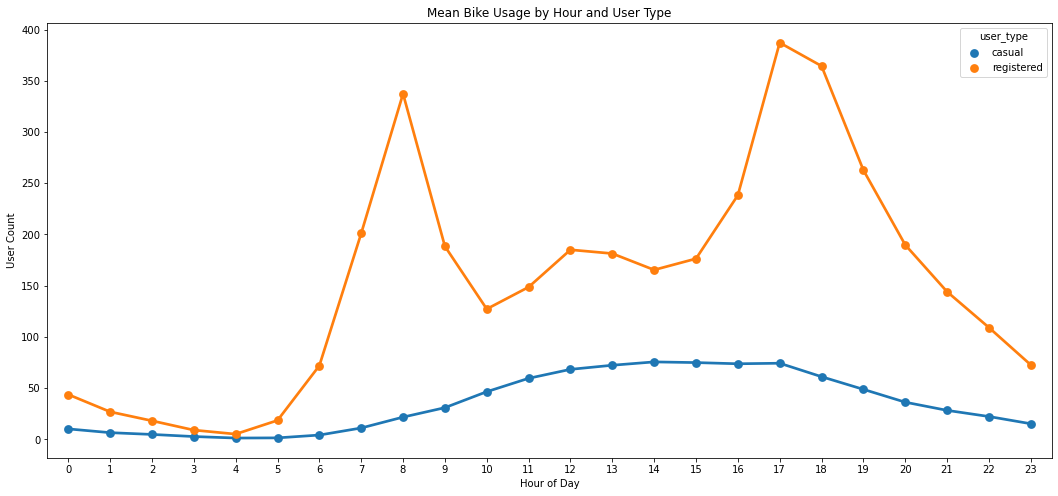

In [25]:
plt.figure(figsize = (18, 8))
sns.pointplot(x = usage_type["hour"], 
              y = usage_type["mean_usage"], 
              hue = usage_type["user_type"], 
              palette = sns.color_palette("tab10"))

plt.xlabel('Hour of Day')
plt.ylabel('User Count')
plt.title('Mean Bike Usage by Hour and User Type')
plt.show()

### Working Day Analysis <a class="anchor" id="section2_5_2"></a>

In [26]:
data_1['Total'] = data_1['casual'] + data_1['registered']

In [27]:
usage_wd = data_1.groupby(['hour', 'workingday'])['Total'].agg('sum').unstack()
usage_wd

workingday,0,1
hour,,
0,20884.0,18246.0
1,15987.0,8177.0
2,12123.0,4229.0
3,5851.0,2323.0
4,1876.0,2552.0
5,1929.0,12332.0
6,4292.0,50840.0
7,10027.0,144144.0
8,24406.0,236595.0


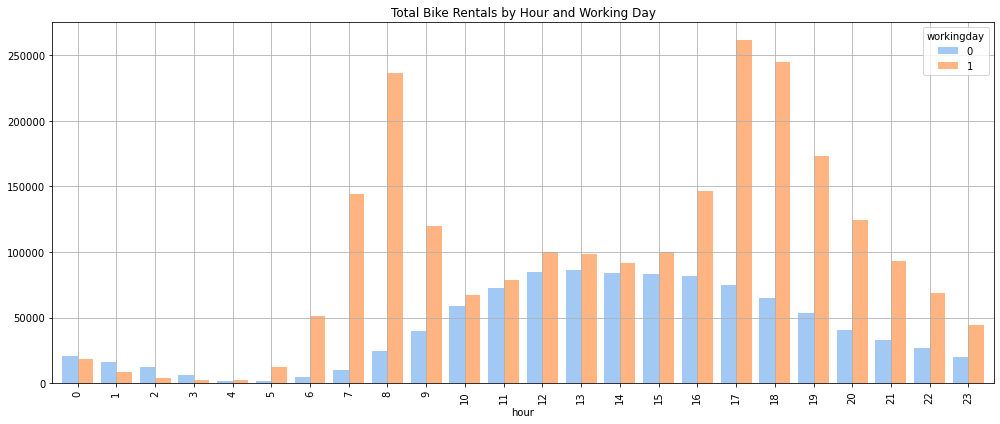

In [28]:
usage_wd.plot(kind = 'bar', figsize = (14, 6), width = 0.8)
plt.grid(True)
plt.title('Total Bike Rentals by Hour and Working Day')
plt.tight_layout()
plt.show()

**Key Observations**  
- Better to schedule maintenance on non-working days, though cost may increase
- Between 0900 to 1800,  maintenance should be targeted during 9am 10am 6pm 11am 5pm 4pm 3pm 2pm 12pm (in order of increasing bike demand)

### Day of Week Analysis <a class="anchor" id="section2_5_3"></a>

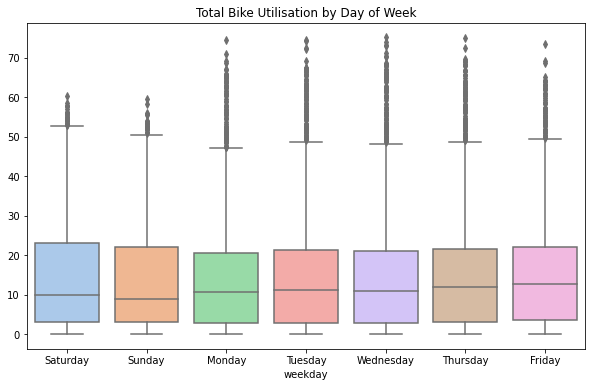

In [29]:
sns.boxplot(x = data_1['weekday'], 
            y = (data_1['casual'] + data_1['registered'])/ 13)\
   .set_title('Total Bike Utilisation by Day of Week')

plt.show()

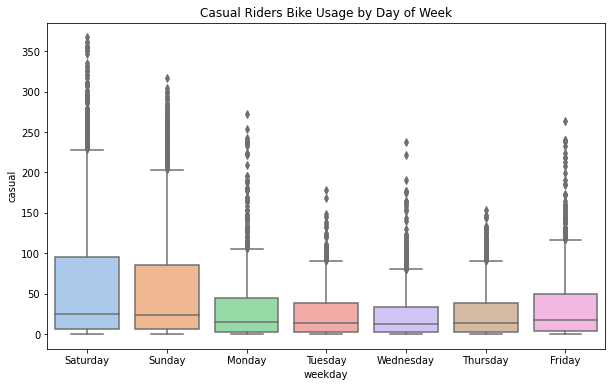

In [30]:
# Bike usage by casual users
sns.boxplot(x = data_1['weekday'], y = data_1['casual']).set_title('Casual Riders Bike Usage by Day of Week')
plt.show()

Casual users mainly use the bikes on weekends. Possible to charge a premium on weekends if the bike utilisation rate is too high to ensure that there are sufficient bikes for registered users. 

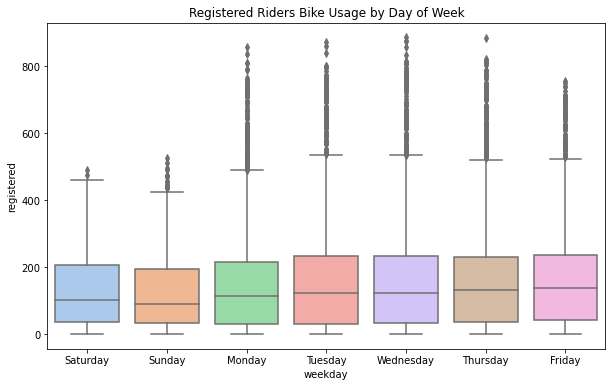

In [31]:
# Bike usage by registered users
sns.boxplot(x = data_1['weekday'], y = data_1['registered']).set_title('Registered Riders Bike Usage by Day of Week')
plt.show()

In [32]:
# Mean bike usage based on hour and weekday
usage_wday = pd.DataFrame({'mean_usage': data_1.groupby(['hour', 'weekday'])['Total'].mean()}).reset_index()

# Sort by ascending weekday
day_map = {'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6}
usage_wday['day'] = usage_wday['weekday'].map(day_map)
usage_wday.sort_values(by = ['hour', 'day'], inplace = True)
usage_wday.drop(columns = ['day'], axis = 1, inplace = True)
usage_wday

,hour,weekday,mean_usage
3,0,Sunday,93.990385
1,0,Monday,34.009524
5,0,Tuesday,27.623762
6,0,Wednesday,34.557692
4,0,Thursday,39.271845
...,...,...,...
166,23,Tuesday,76.173077
167,23,Wednesday,83.737864
165,23,Thursday,96.750000
161,23,Friday,115.211538


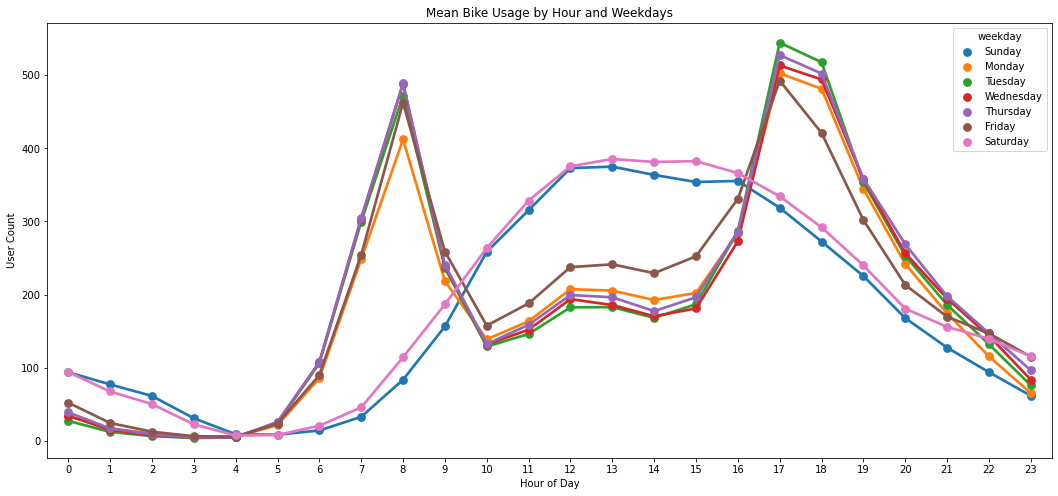

In [33]:
plt.figure(figsize = (18, 8))
sns.pointplot(x = usage_wday["hour"], 
              y = usage_wday["mean_usage"], 
              hue = usage_wday["weekday"], 
              hue_order = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], 
              palette = sns.color_palette("tab10"))

plt.xlabel('Hour of Day')
plt.ylabel('User Count')
plt.title('Mean Bike Usage by Hour and Weekdays')
plt.show()

**Key Observations** 
- Weekday and weekends usage patterns is observed to be very different
- Weekday:
    - High demand during 0700 to 0900 (peak at 0800), and 1600 to 2000 (peaks at 1700 and 1800)
    - Medium demand during 0900 to 1600
    - Low demand during 2000 to 0700
- Weekend:
    - High demand between 1200 to 1500
    - Medium demand during 0800 to 1200 and 1500 to 2000
    - Low demand during 2000 to 0800

### Weather Situation Analysis <a class="anchor" id="section2_5_4"></a>

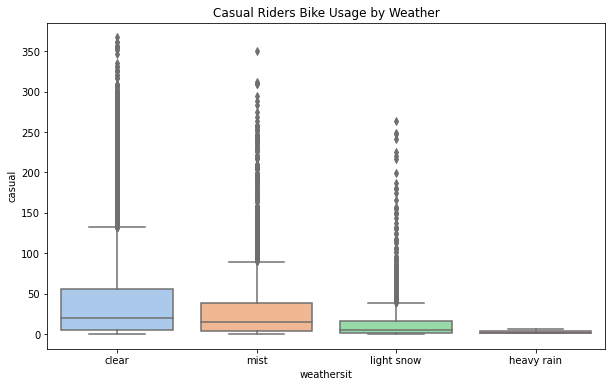

In [34]:
# Bike usage by casual users
sns.boxplot(x = data_1['weathersit'], y = data_1['casual']).set_title('Casual Riders Bike Usage by Weather')
plt.show()

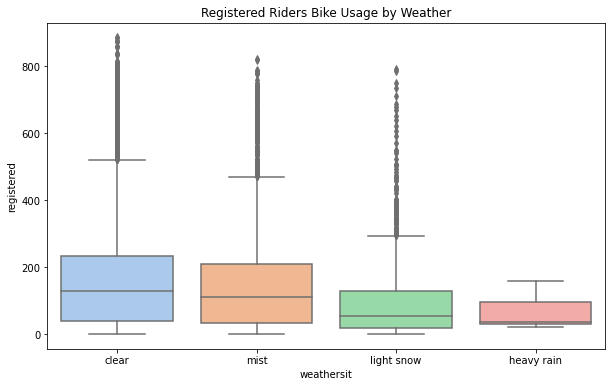

In [35]:
# Bike usage by registered users
sns.boxplot(x = data_1['weathersit'], y = data_1['registered']).set_title('Registered Riders Bike Usage by Weather')
plt.show()

Both casual and registered users follow the same trend in that they are more likely to use the bikes when the weather is good i.e. clear.

In [36]:
usage_wsit = pd.DataFrame({'mean_usage': data_1.dropna().groupby(['hour', 'weathersit'])['Total'].mean()}).reset_index()
usage_wsit

,hour,weathersit,mean_usage
0,0,clear,59.161554
1,0,light snow,28.115385
2,0,mist,47.232432
3,1,clear,34.395918
4,1,heavy rain,23.000000
...,...,...,...
70,22,light snow,70.345455
71,22,mist,116.823171
72,23,clear,93.981707
73,23,light snow,49.373134


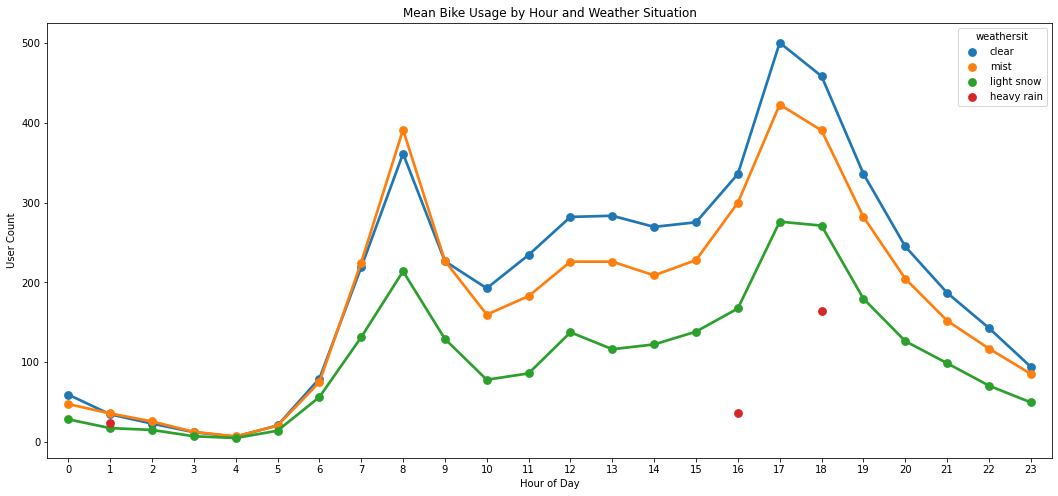

In [37]:
plt.figure(figsize = (18, 8))
sns.pointplot(x = usage_wsit["hour"], 
              y = usage_wsit["mean_usage"], 
              hue = usage_wsit["weathersit"], 
              hue_order = ["clear", "mist", "light snow", "heavy rain"], 
              palette = sns.color_palette("tab10"))

plt.xlabel('Hour of Day')
plt.ylabel('User Count')
plt.title('Mean Bike Usage by Hour and Weather Situation')
plt.show()

**Key Observations**
- Hourly usage trends remain the same (shape) regardless of weather
- Peak and non-peak hours are largely similar 
- Maintenance schedule can largely be the same throughout the year

### Season Analysis <a class="anchor" id="section2_5_5"></a>

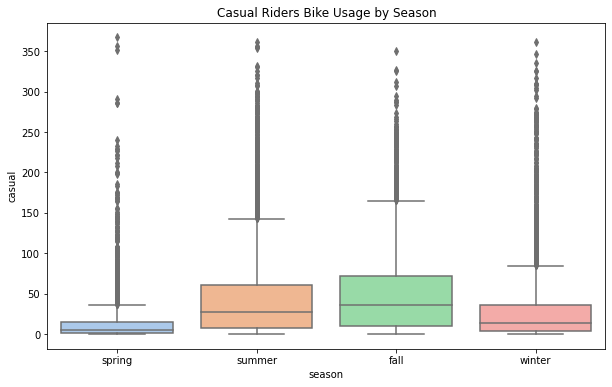

In [38]:
# Bike usage by casual users
sns.boxplot(x = data_1['season'], y = data_1['casual']).set_title('Casual Riders Bike Usage by Season')
plt.show()

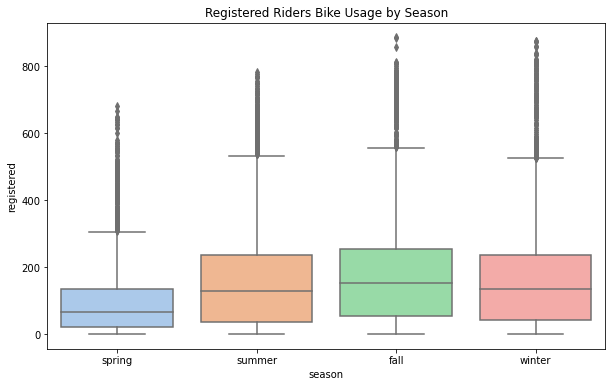

In [39]:
# Bike usage by registered users
sns.boxplot(x = data_1['season'], y = data_1['registered']).set_title('Registered Riders Bike Usage by Season')
plt.show()

Registered users seem to use the bikes even in the winter (healthy level of demand observed), when the weather is cold. A possible explanation could be that traffic conditions are worsen by snow, thus necessitating the use of bikes as an alternative means of transport around the city.

# Regression Modelling <a class="anchor" id="section3"></a>

## Feature Engineering <a class="anchor" id="section3_1"></a>

In [40]:
# Remove NA values 
# Not a concern since it only constitutes ~1% of dataset i.e not too much data_loss
data_clean = data_1.dropna()
data_clean.shape

(17379, 18)

### Dependent y-variable - Bike Utilisation <a class="anchor" id="section3_1_1"></a>

In [41]:
# Assume a constant total of 1300 bikes
data_2 = data_clean.copy()
data_2['bike_utilisation'] = (data_clean['casual'] + data_clean['registered']) / 1300 * 100

In [42]:
# Summary statistics for bike_utilisation
data_2[['bike_utilisation']].describe()

,bike_utilisation
count,17379.000000
mean,14.574084
std,13.952892
min,0.076923
25%,3.076923
50%,10.923077
75%,21.615385
max,75.153846


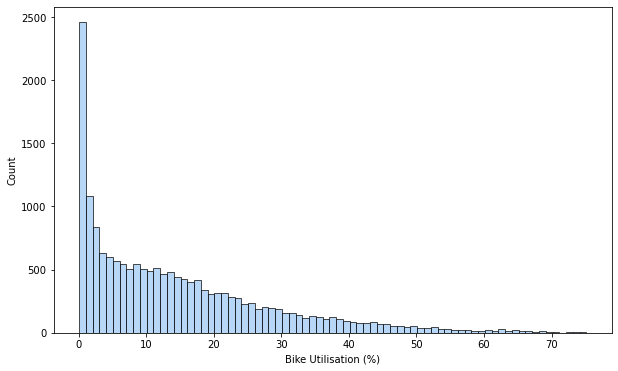

In [43]:
# Plot histogram of bike_utilisation
sns.histplot(x = 'bike_utilisation', data = data_2, bins = 75)
plt.xlabel('Bike Utilisation (%)')
plt.show()

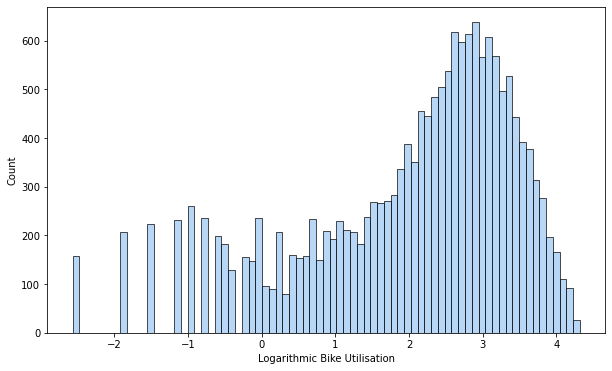

In [44]:
# Apply and visualise log transformation
data_2['bike_utilisation_lg'] = np.log(data_2['bike_utilisation'])

# Visualise log transformation
sns.histplot(x = 'bike_utilisation_lg', data = data_2, bins = 75)
plt.xlabel('Logarithmic Bike Utilisation')
plt.show()

### Correlation Analysis <a class="anchor" id="section3_1_2"></a>

In [45]:
# Generate correlation matrix for X variables
corr = data_2.drop(columns = ['index', 'Time', 'Total', 'bike_utilisation', 'bike_utilisation_lg'], axis = 1).corr()
corr

,year_2012,month,day,hour,holiday,workingday,temp,atemp,hum,windspeed,casual,registered
year_2012,1.000000,-0.010473,0.002057,-0.003867,0.006692,-0.002196,0.040913,0.039222,-0.083546,-0.008740,0.142779,0.253684
month,-0.010473,1.000000,0.007929,-0.005772,0.018430,-0.003477,0.201691,0.208096,0.164411,-0.135386,0.068457,0.122273
day,0.002057,0.007929,1.000000,0.001538,-0.010132,0.008627,0.027180,0.021269,0.025663,0.010505,-0.003283,-0.004098
hour,-0.003867,-0.005772,0.001538,1.000000,0.000479,0.002285,0.137603,0.133750,-0.276498,0.137252,0.301202,0.374141
holiday,0.006692,0.018430,-0.010132,0.000479,1.000000,-0.252471,-0.027340,-0.030973,-0.010588,0.003988,0.031564,-0.047345
workingday,-0.002196,-0.003477,0.008627,0.002285,-0.252471,1.000000,0.055390,0.054667,0.015688,-0.011830,-0.300942,0.134326
temp,0.040913,0.201691,0.027180,0.137603,-0.027340,0.055390,1.000000,0.987672,-0.069881,-0.023125,0.459616,0.335361
atemp,0.039222,0.208096,0.021269,0.133750,-0.030973,0.054667,0.987672,1.000000,-0.051918,-0.062336,0.454080,0.332559
hum,-0.083546,0.164411,0.025663,-0.276498,-0.010588,0.015688,-0.069881,-0.051918,1.000000,-0.290105,-0.347028,-0.273933
windspeed,-0.008740,-0.135386,0.010505,0.137252,0.003988,-0.011830,-0.023125,-0.062336,-0.290105,1.000000,0.090287,0.082321


<AxesSubplot:>

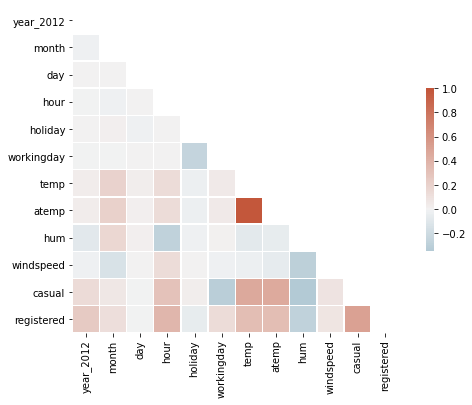

In [46]:
# Plot and visualise correlation matrix
mask = np.triu(np.ones_like(corr, dtype = bool))

cmap = sns.diverging_palette(230, 20, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0,
            square = True, linewidths = 0.5, cbar_kws = {"shrink": 0.5})

### Categorical Dummy Variables <a class="anchor" id="section3_1_3"></a>

In [47]:
data_new = pd.get_dummies(data_2, columns = ['hour', 'day', 'month', 'season', 'weekday', 'weathersit'])
data_new.head()

,index,Time,year_2012,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,Total,bike_utilisation,bike_utilisation_lg,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,day_1,day_2,day_3,day_4,day_5,day_6,day_7,day_8,day_9,day_10,day_11,day_12,day_13,day_14,day_15,day_16,day_17,day_18,day_19,day_20,day_21,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,season_fall,season_spring,season_summer,season_winter,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_clear,weathersit_heavy rain,weathersit_light snow,weathersit_mist
0,1.0,2011-01-01 00:00:00,0,0,0,0.24,0.2879,0.81,0.0,3.0,13.0,16.0,1.230769,0.207639,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
1,2.0,2011-01-01 01:00:00,0,0,0,0.22,0.2727,0.80,0.0,8.0,32.0,40.0,3.076923,1.123930,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
2,3.0,2011-01-01 02:00:00,0,0,0,0.22,0.2727,0.80,0.0,5.0,27.0,32.0,2.461538,0.900787,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,4.0,2011-01-01 03:00:00,0,0,0,0.24,0.2879,0.75,0.0,3.0,10.0,13.0,1.000000,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0
4,5.0,2011-01-01 04:00:00,0,0,0,0.24,0.2879,0.75,0.0,0.0,1.0,1.0,0.076923,-2.564949,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0


In [48]:
data_new.shape

(17379, 96)

In [49]:
data_new.columns

Index(['index', 'Time', 'year_2012', 'holiday', 'workingday', 'temp', 'atemp',
       'hum', 'windspeed', 'casual', 'registered', 'Total', 'bike_utilisation',
       'bike_utilisation_lg', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4',
       'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11',
       'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17',
       'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23',
       'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8',
       'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15',
       'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22',
       'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29',
       'day_30', 'day_31', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12', 'season_fall', 'season_spring', 'season_summer',
  

## Model Preparation <a class="anchor" id="section3_2"></a>

In [50]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

### Train-test Split <a class="anchor" id="section3_2_2"></a>

In [51]:
# Information from 'Time' column has already been extracted out as categorical features
X = data_new.drop(columns = ['index', 'Time', 'atemp', 'casual', 'registered', 'Total', 
                             'bike_utilisation', 'bike_utilisation_lg'], axis = 1)

y = data_new[['bike_utilisation']]

print(X.shape)
print(y.shape)

(17379, 88)
(17379, 1)


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 4811)

print(X_train.shape)
print(X_test.shape)

(13034, 88)
(4345, 88)


### Cross-Validation Performance Evaluation Function <a class="anchor" id="section3_2_3"></a>

In [53]:
def evaluate_performance(model_list, X_train, y_train, n, index_list):
    
    # Empty list for performance metrics
    rmse_scores = []
    r2_scores = []

    # Cross-validation scoring for each model 
    for model in model_list:
        mse = abs(cross_val_score(model, X_train, y_train, cv = n, scoring = 'neg_mean_squared_error'))
        rmse = (np.mean(mse))**0.5
        
        r2 = np.mean(cross_val_score(model, X_train, y_train, cv = n, scoring = 'r2'))
    
        rmse_scores.append(rmse)
        r2_scores.append(r2)
    
    # Return dataframe of model performances
    return pd.DataFrame({'Root Mean Squared Logarithmic Error': rmse_scores, 
                         'R2 Value': r2_scores}, index = index_list)

### Variable Importance Visualisation Function <a class="anchor" id="section3_2_4"></a>

In [54]:
def visualise_importance(model, X_train, n):
    
    # Create dataframe of features and importances
    dataframe = pd.DataFrame({'Features':   list(X_train.columns), 
                              'Importance': list(model.feature_importances_)})\
                  .sort_values(by = ['Importance'], ascending = False)
    
    # Return horizontal barplot
    return sns.barplot(data = dataframe.iloc[:n, :], x = 'Importance', y = 'Features')

## OLS Linear Regression <a class="anchor" id="section3_3"></a>

### Evaluating y-variable Transformations <a class="anchor" id="section3_3_1"></a>

In [55]:
def test_linear_transformation(Regressor, X, y):
    
    # No Transformation
    lm_1 = Regressor.fit(X, y).score(X, y)

    # Log y-Transformation
    lm_2 = Regressor.fit(X, np.log(y)).score(X, np.log(y))
    
    # Square Root y-Transformation
    lm_3 = Regressor.fit(X, np.sqrt(y)).score(X, np.sqrt(y))
    
    # Square y-Transformation
    lm_4 = Regressor.fit(X, np.square(y)).score(X, np.square(y))
        
    return pd.DataFrame({'X-Transformation': ['None', 'None', 'None', 'None'],
                         'y-Transformation': ['None', 'Log', 'Square Root', 'Square'],
                         'R2 Score': [lm_1, lm_2, lm_3, lm_4]})

In [56]:
test_linear_transformation(LinearRegression(), X_train, y_train)

,X-Transformation,y-Transformation,R2 Score
0,None,None,0.689091
1,None,Log,0.824784
2,None,Square Root,0.786950
3,None,Square,0.521622


In [57]:
# Log transformation shown to have highest training R2 value
y_train = np.log(y_train)
y_test  = np.log(y_test)

### L1 Regularisation for Variable Selection <a class="anchor" id="section3_3_2"></a>

In [58]:
# Normalize each variable for determining best alpha i.e. regularisation coefficient through CV
scaler = StandardScaler()
scaler.fit(X_train)

X_train_new = scaler.transform(X_train)
X_test_new  = scaler.transform(X_test)

In [59]:
# Determine number of variables at each alpha value for Lasso Regression
alpha_values = np.arange(0.01, 0.21, 0.01)

lasso_models = GridSearchCV(estimator = Lasso(), 
                            param_grid = {'alpha': alpha_values}, 
                            scoring = 'neg_mean_squared_error',
                            cv = 5, 
                            refit = True, 
                            return_train_score = True).fit(X_train_new, y_train)

variable_lst = []

for i in alpha_values:
    model = Lasso(alpha = i).fit(X_train_new, y_train)
    variable_lst.append(np.count_nonzero(model.coef_))

# Store cross-validation results 
results_lst  = abs(lasso_models.cv_results_['mean_test_score'])**0.5

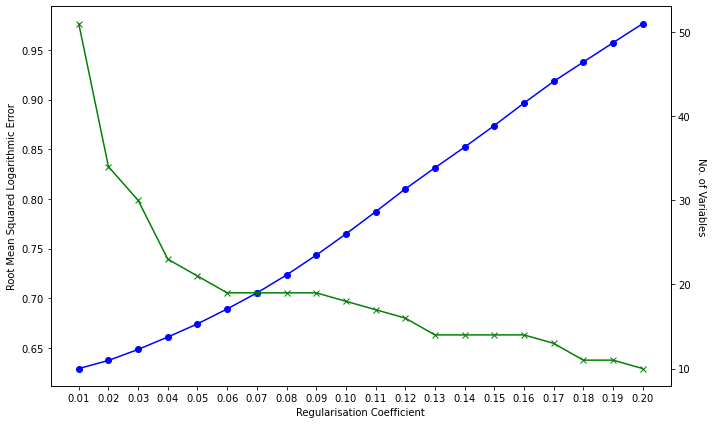

<Figure size 720x504 with 0 Axes>

In [60]:
# Plot performance metric for different alpha values
fig, ax1 = plt.subplots()

ax1.set_xticks(alpha_values)
ax1.set_xlabel('Regularisation Coefficient')
ax1.set_ylabel('Root Mean Squared Logarithmic Error')
ax1.plot(alpha_values, results_lst, '-o', color = 'blue')

ax2 = ax1.twinx()
ax2.set_ylabel('No. of Variables', rotation = 270, labelpad = 15)
ax2.plot(alpha_values, variable_lst, '-x', color = 'green')

fig.tight_layout()
plt.figure(figsize = (10, 7))
plt.show()

In [61]:
# DataFrame showing alpha value and no. of variables 
lasso_results = pd.DataFrame({'Regularisation Coefficient': alpha_values,
                              'Number of Variables': variable_lst, 
                              'Root Mean Squared Error': results_lst})
lasso_results

,Regularisation Coefficient,Number of Variables,Root Mean Squared Error
0,0.01,51,0.629195
1,0.02,34,0.637352
2,0.03,30,0.648466
3,0.04,23,0.660956
4,0.05,21,0.674216
5,0.06,19,0.689244
6,0.07,19,0.705319
7,0.08,19,0.723423
8,0.09,19,0.743407
9,0.10,18,0.764727


In [62]:
# Choose alpha and determine which variables are selected
lasso_lm = Lasso(alpha = 0.03).fit(X_train_new, y_train)

results  = {X_train.columns[i]: list(lasso_lm.coef_)[i] for i in range(len(X_train.columns))}

selected_lm = [k for k, v in results.items() if round(v, 5) != 0]
print(selected_lm)

['year_2012', 'holiday', 'temp', 'hum', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_8', 'hour_9', 'hour_12', 'hour_13', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_22', 'hour_23', 'month_1', 'month_5', 'month_7', 'season_spring', 'season_winter', 'weekday_Friday', 'weekday_Saturday', 'weathersit_light snow']


### Comparing OLS Regularised Models  <a class="anchor" id="section3_3_3"></a>

In [63]:
def coefficients_table(model, X_train, n):
    
    coef_list = list(model.coef_.flatten())
    
    # Create dataframe of features and coefficient
    dataframe = pd.DataFrame({'Features':   list(X_train.columns), 
                              'Coefficient Sign': ['+' if cf >= 0 else '-' for cf in coef_list],
                              'Coefficient Magnitude': [abs(cf) for cf in coef_list]})\
                  .sort_values(by = ['Coefficient Magnitude'], ascending = False)
    
    # Return trimmed dataframe 
    return dataframe.iloc[:n, :].reset_index(drop = True)

In [64]:
# Fit Ridge model with all variables (keep all variables small)
lm_ridge = Ridge(alpha = 1)

# Top 10 features and their coefficients
coefficients_table(lm_ridge.fit(X_train, y_train), X_train, 10)

,Features,Coefficient Sign,Coefficient Magnitude
0,hour_4,-,2.841006
1,hour_3,-,2.533389
2,hour_2,-,1.982732
3,hour_5,-,1.730046
4,temp,+,1.422377
5,hour_1,-,1.381439
6,hour_17,+,1.348852
7,hour_18,+,1.267290
8,hour_8,+,1.103506
9,hour_19,+,1.003870


In [65]:
# Fit Lasso model with alpha = 0.03
lm_lasso = LinearRegression()

# Top 10 features and their coefficients
coefficients_table(lm_lasso.fit(X_train[selected_lm], y_train), X_train[selected_lm], 10)

,Features,Coefficient Sign,Coefficient Magnitude
0,hour_4,-,3.345273
1,hour_3,-,3.037741
2,hour_2,-,2.487015
3,hour_5,-,2.226172
4,hour_1,-,1.887137
5,temp,+,1.612668
6,hour_0,-,1.292370
7,hour_6,-,1.043643
8,hour_17,+,0.797356
9,hour_18,+,0.723011


In [66]:
# CV Performance of both OLS Regularised Models
ols_perf = pd.concat([evaluate_performance([lm_ridge], X_train, y_train, 10, ['Ridge']), 
                      evaluate_performance([lm_lasso], X_train[selected_lm], y_train, 10, ['LASSO'])], axis = 0)

# Add in regularisation parameter and number of variables 
ols_perf['Penalty Parameter'] = [1, 0.03]
ols_perf['No. of Variables']  = [len(lm_ridge.coef_.flatten()), len(lm_lasso.coef_.flatten())]

ols_perf

,Root Mean Squared Logarithmic Error,R2 Value,Penalty Parameter,No. of Variables
Ridge,0.625737,0.822384,1.00,88
LASSO,0.629625,0.820152,0.03,30


In [67]:
# Fit LASSO model 
lm_lasso.fit(X_train[selected_lm], y_train)

LinearRegression()

## Decision Tree <a class="anchor" id="section3_4"></a>

### Hyperparameter Tuning via Grid Search  <a class="anchor" id="section3_4_1"></a>

In [68]:
parameters = {'criterion': ['mse'], 
              'max_depth': [5, 10, 15, 20],
              'min_samples_split': np.arange(10, 60, 10)}

reg_tree = GridSearchCV(estimator = DecisionTreeRegressor(), 
                        param_grid = parameters, 
                        scoring = 'neg_mean_squared_error',
                        cv = 10, 
                        refit = True)

reg_tree.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse'], 'max_depth': [5, 10, 15, 20],
                         'min_samples_split': array([10, 20, 30, 40, 50])},
             scoring='neg_mean_squared_error')

In [69]:
# Return all CV results
reg_tree_results = pd.concat([pd.DataFrame(reg_tree.cv_results_['params']), 
                              pd.DataFrame(abs(reg_tree.cv_results_['mean_test_score'])**0.5, 
                                           columns = ['mean_CV_RMSE'])], 
                             axis = 1)
reg_tree_results

,criterion,max_depth,min_samples_split,mean_CV_RMSE
0,mse,5,10,0.923430
1,mse,5,20,0.923557
2,mse,5,30,0.923461
3,mse,5,40,0.923378
4,mse,5,50,0.923216
5,mse,10,10,0.651326
6,mse,10,20,0.649305
7,mse,10,30,0.646782
8,mse,10,40,0.646098
9,mse,10,50,0.646179


In [70]:
dt_params = reg_tree.best_params_
dt_params

{'criterion': 'mse', 'max_depth': 20, 'min_samples_split': 30}

In [71]:
# Evaluate Best Decision Tree performance
evaluate_performance([DecisionTreeRegressor(**dt_params)], X_train, y_train, 10, ['Decision Tree'])

,Root Mean Squared Logarithmic Error,R2 Value
Decision Tree,0.472189,0.898999


<AxesSubplot:xlabel='Importance', ylabel='Features'>

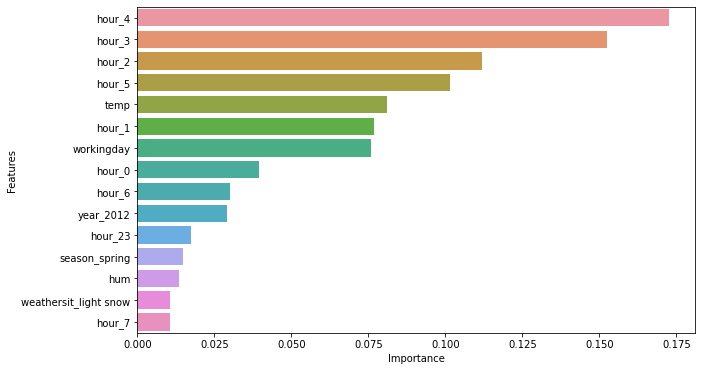

In [72]:
# Visualise Best Decision Tree Feature Importance 
visualise_importance(DecisionTreeRegressor(**dt_params).fit(X_train, y_train), X_train, 15)

### Selecting Top Features for Pruned Tree  <a class="anchor" id="section3_4_2"></a>

In [73]:
# Extract only the hour, temp and workingday columns
selected_dt = [i for i in X_train.columns if ((i.find('hour') >= 0) | 
                                              (i.find('temp') >= 0) | 
                                              (i.find('workingday') >= 0) | 
                                              (i.find('season') >= 0))]
len(selected_dt)

30

In [74]:
# Evaluate pruned Decision Tree performance
dt_perf = evaluate_performance([DecisionTreeRegressor(**dt_params)], 
                               X_train[selected_dt], y_train, 10, ['Decision Tree'])
dt_perf

,Root Mean Squared Logarithmic Error,R2 Value
Decision Tree,0.532716,0.871155


In [75]:
# Fit best DT tree with selected features
dt_best = DecisionTreeRegressor(**dt_params, random_state = 48)
dt_best.fit(X_train[selected_dt], y_train)

DecisionTreeRegressor(max_depth=20, min_samples_split=30, random_state=48)

## Random Forest  <a class="anchor" id="section3_5"></a>

### Hyperparameter Tuning via Randomised Search  <a class="anchor" id="section3_5_1"></a>

In [76]:
parameters = {'max_features': [9, 18, 27, 36], 
              'max_depth': [15, 20],
              'min_samples_split': np.arange(10, 60, 10),
              'n_estimators': [100, 300, 500]}

reg_rf = RandomizedSearchCV(estimator = RandomForestRegressor(), 
                            n_iter = 20, 
                            param_distributions = parameters,
                            scoring = 'neg_mean_squared_error',
                            cv = 10, 
                            refit = True, 
                            n_jobs = 4)

reg_rf.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=10, estimator=RandomForestRegressor(), n_iter=20,
                   n_jobs=4,
                   param_distributions={'max_depth': [15, 20],
                                        'max_features': [9, 18, 27, 36],
                                        'min_samples_split': array([10, 20, 30, 40, 50]),
                                        'n_estimators': [100, 300, 500]},
                   scoring='neg_mean_squared_error')

In [77]:
# Return all CV results
rf_results = pd.concat([pd.DataFrame(reg_rf.cv_results_['params']), 
                        pd.DataFrame(abs(reg_rf.cv_results_['mean_test_score'])**0.5, 
                                     columns = ['mean_CV_RMSE'])], 
                       axis = 1)
rf_results

,n_estimators,min_samples_split,max_features,max_depth,mean_CV_RMSE
0,100,20,27,15,0.487685
1,100,30,18,15,0.533692
2,500,30,27,15,0.494917
3,500,10,36,20,0.406154
4,500,50,27,15,0.513156
5,500,50,9,15,0.662511
6,500,40,9,20,0.583263
7,300,50,18,20,0.505141
8,100,20,27,20,0.432368
9,100,30,18,20,0.479044


In [78]:
rf_params = reg_rf.best_params_
rf_params

{'n_estimators': 500,
 'min_samples_split': 10,
 'max_features': 36,
 'max_depth': 20}

In [79]:
# Evaluate Random Forest performance
rf_perf = evaluate_performance([RandomForestRegressor(**rf_params)], 
                               X_train, y_train.values.ravel(), 10, ['Random Forest'])
rf_perf

,Root Mean Squared Logarithmic Error,R2 Value
Random Forest,0.406341,0.925214


<AxesSubplot:xlabel='Importance', ylabel='Features'>

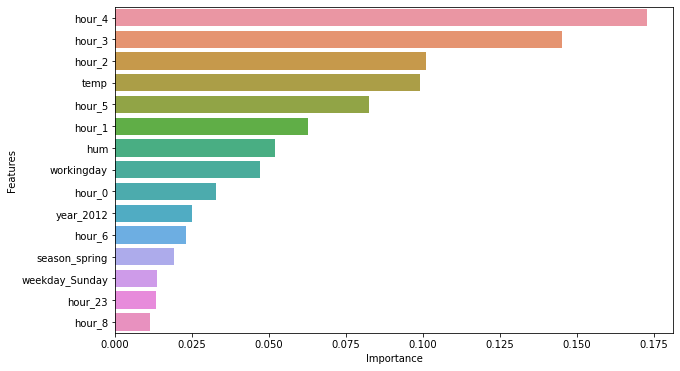

In [80]:
# Visualise Random Forest Feature Importance 
visualise_importance(RandomForestRegressor(**rf_params).fit(X_train, y_train.values.ravel()), X_train, 15)

### Selecting Top Features  <a class="anchor" id="section3_5_2"></a>

In [81]:
# Extract only the hour, temp, hum and workingday columns
selected_rf = [i for i in X_train.columns if ((i.find('hour') >= 0) | 
                                              (i.find('temp') >= 0) | 
                                              (i.find('workingday') >= 0) | 
                                              (i.find('hum') >= 0) | 
                                              (i.find('season') >= 0))]
len(selected_rf)

31

In [82]:
# Best RF model with selected features 
rf_best = RandomForestRegressor(n_estimators = rf_params['n_estimators'],
                                max_features = 27, 
                                min_samples_split = rf_params['min_samples_split'],
                                max_depth = rf_params['max_depth'],
                                random_state = 48)

In [83]:
# Evaluate feature selected RF performance
rf_perf = evaluate_performance([rf_best], X_train[selected_rf], y_train.values.ravel(), 10, ['Random Forest'])
rf_perf

,Root Mean Squared Logarithmic Error,R2 Value
Random Forest,0.484291,0.893623


In [84]:
# Fit best RF Model
rf_best.fit(X_train[selected_rf], y_train.values.ravel())

RandomForestRegressor(max_depth=20, max_features=27, min_samples_split=10,
                      n_estimators=500, random_state=48)

## Gradient Boost  <a class="anchor" id="section3_6"></a>

### Hyperparameter Tuning via Randomised Search  <a class="anchor" id="section3_6_1"></a>

In [85]:
parameters = {'learning_rate': np.arange(0.05, 0.75, 0.05), 
              'max_depth': [2, 3],
              'n_estimators': [100, 300, 500]}

reg_gb = RandomizedSearchCV(estimator = GradientBoostingRegressor(), 
                            n_iter = 20, 
                            param_distributions = parameters,
                            scoring = 'neg_mean_squared_error',
                            cv = 10, 
                            refit = True, 
                            n_jobs = 4)

reg_gb.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(), n_iter=20,
                   n_jobs=4,
                   param_distributions={'learning_rate': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 ]),
                                        'max_depth': [2, 3],
                                        'n_estimators': [100, 300, 500]},
                   scoring='neg_mean_squared_error')

In [86]:
# Return all CV results
gb_results = pd.concat([pd.DataFrame(reg_gb.cv_results_['params']), 
                        pd.DataFrame(abs(reg_gb.cv_results_['mean_test_score'])**0.5, 
                                     columns = ['mean_CV_RMSE'])], 
                       axis = 1)
gb_results

,n_estimators,max_depth,learning_rate,mean_CV_RMSE
0,500,2,0.05,0.491726
1,500,2,0.15,0.396151
2,300,3,0.05,0.472360
3,100,3,0.05,0.661898
4,500,3,0.20,0.343389
5,100,2,0.30,0.475998
6,500,2,0.20,0.387499
7,300,2,0.20,0.411875
8,300,3,0.15,0.376035
9,300,3,0.55,0.343566


In [87]:
gb_params = reg_gb.best_params_
gb_params

{'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.45}

In [88]:
# Evaluate Gradient Boosting performance
gb_perf = evaluate_performance([GradientBoostingRegressor(**gb_params)], 
                               X_train, y_train.values.ravel(), 10, ['Gradient Boost'])
gb_perf

,Root Mean Squared Logarithmic Error,R2 Value
Gradient Boost,0.337011,0.948529


<AxesSubplot:xlabel='Importance', ylabel='Features'>

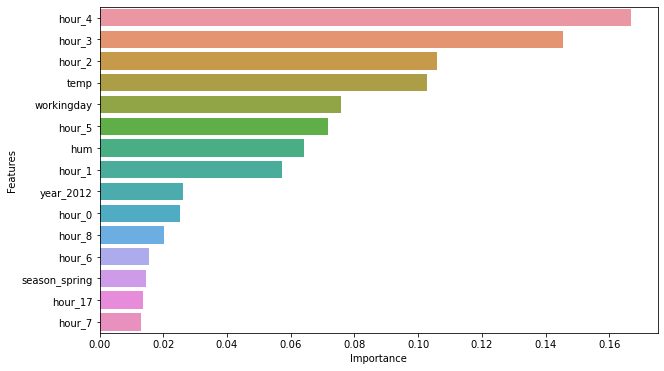

In [89]:
# Visualise Gradient Boosting Feature Importance 
visualise_importance(GradientBoostingRegressor(**gb_params).fit(X_train, y_train.values.ravel()), X_train, 15)

### Selecting Top Features  <a class="anchor" id="section3_6_2"></a>

In [90]:
# Extract only the hour, temp, hum and workingday columns
selected_gb = [i for i in X_train.columns if ((i.find('hour') >= 0) | 
                                              (i.find('temp') >= 0) | 
                                              (i.find('workingday') >= 0) | 
                                              (i.find('hum') >= 0) | 
                                              (i.find('season') >= 0))]
len(selected_gb)

31

In [91]:
# Best GB model with selected features 
gb_best = GradientBoostingRegressor(**gb_params, random_state = 48)

In [92]:
# Evaluate feature selected GB performance
gb_perf = evaluate_performance([gb_best], X_train[selected_gb], y_train.values.ravel(), 10, ['Gradient Boost'])
gb_perf

,Root Mean Squared Logarithmic Error,R2 Value
Gradient Boost,0.47051,0.899604


In [93]:
# Fit best GB Model
gb_best.fit(X_train[selected_gb], y_train.values.ravel())

GradientBoostingRegressor(learning_rate=0.45, n_estimators=500, random_state=48)

## Summary of Models <a class="anchor" id="section3_7"></a>

### In-sample CV Performance <a class="anchor" id="section3_7_1"></a>

In [94]:
in_sample = pd.concat([ols_perf.iloc[[1], :2],
                       dt_perf,
                       rf_perf,
                       gb_perf], axis = 0)

# Convert log RMSE into actual RMSE based on bike utilisation %
in_sample['RMSE (%)'] = np.exp(in_sample['Root Mean Squared Logarithmic Error'])
in_sample

,Root Mean Squared Logarithmic Error,R2 Value,RMSE (%)
LASSO,0.629625,0.820152,1.876907
Decision Tree,0.532716,0.871155,1.703552
Random Forest,0.484291,0.893623,1.623024
Gradient Boost,0.470510,0.899604,1.600810


### Out-of-sample Performance <a class="anchor" id="section3_7_2"></a>

In [95]:
def prediction_capabilities(model, X_test, y_test):
    
    # Obtain y predictions
    y_pred = model.predict(X_test)
    
    # Calculate Out-of-sample R2
    R2 = r2_score(y_test.values.ravel(), y_pred)
    
    # Calculate Out-of-sample RMSE
    RMSE = mean_squared_error(y_test.values.ravel(), y_pred)**0.5
    
    return (R2, RMSE)

In [96]:
lm_test = prediction_capabilities(lm_lasso, X_test[selected_lm], y_test)
dt_test = prediction_capabilities(dt_best,  X_test[selected_dt], y_test)
rf_test = prediction_capabilities(rf_best,  X_test[selected_rf], y_test)
gb_test = prediction_capabilities(gb_best,  X_test[selected_gb], y_test)

In [97]:
out_sample = pd.DataFrame({'Root Mean Squared Logarithmic Error': [lm_test[1], dt_test[1], rf_test[1], gb_test[1]], 
                           'R2 Value': [lm_test[0], dt_test[0], rf_test[0], gb_test[0]]}, 
                          index = ['LASSO', 'Decision Tree', 'Random Forest', 'Gradient Boost'])

# Convert log RMSE into actual RMSE based on bike utilisation %
out_sample['RMSE (%)'] = np.exp(out_sample['Root Mean Squared Logarithmic Error'])
out_sample

,Root Mean Squared Logarithmic Error,R2 Value,RMSE (%)
LASSO,0.628386,0.821309,1.874582
Decision Tree,0.533614,0.871144,1.705083
Random Forest,0.479227,0.896072,1.614826
Gradient Boost,0.461269,0.903715,1.586085


# Time Series Analysis <a class="anchor" id="section4"></a>

## Data Preparation for Time Series <a class="anchor" id="section4_1"></a>

In [98]:
# Create new column containing bike utilisation
data['bike_utilisation'] = (data['casual'] + data['registered']) / 1300

In [99]:
y = data[['Time', 'bike_utilisation']].set_index('Time')
y.head(5)

,bike_utilisation
Time,
2011-01-01 00:00:00,0.012308
2011-01-01 01:00:00,0.030769
2011-01-01 02:00:00,0.024615
2011-01-01 03:00:00,0.010000
2011-01-01 04:00:00,0.000769


In [100]:
# Change index to DateTimeIndex
y.index = pd.to_datetime(y.index)

In [101]:
# Obtain frequency from index
freq = pd.infer_freq(y.index)
freq

'H'

In [102]:
# Interpolate all missing values
y.interpolate(limit_area = 'inside', inplace = True)

In [103]:
# Create test set for last week 
y_train = y.iloc[:17472, :]
y_test  = y.iloc[17472:, :]

print(y_train.shape)
print(y_test.shape)

(17472, 1)
(72, 1)


## ARIMA Modelling <a class="anchor" id="section4_2"></a>

In [104]:
import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [105]:
from statsmodels.tsa.arima_model import ARIMA

In [106]:
# Build the basic model
model = ARIMA(y_train, (1, 1, 2), freq = freq).fit(transparams = True)
print(model.summary())

                             ARIMA Model Results                              
Dep. Variable:     D.bike_utilisation   No. Observations:                17471
Model:                 ARIMA(1, 1, 2)   Log Likelihood               22560.585
Method:                       css-mle   S.D. of innovations              0.067
Date:                Tue, 20 Apr 2021   AIC                         -45111.169
Time:                        00:13:29   BIC                         -45072.328
Sample:                    01-01-2011   HQIC                        -45098.378
                         - 12-28-2012                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     4.722e-06   6.71e-06      0.704      0.481   -8.42e-06    1.79e-05
ar.L1.D.bike_utilisation     0.6884      0.006    112.562      0.000       0.676       0.

### In-sample Performance Analysis <a class="anchor" id="section4_2_1"></a>

In [107]:
# Predict using fitted model
y_pred = model.predict(y_train.index[1], y_train.index[-1], typ = 'levels')

In [108]:
# Combine y_train and y_pred together
arima_results = pd.concat([y_train[1:], y_pred.rename('forecast_utilisation')], axis = 1)
arima_results

,bike_utilisation,forecast_utilisation
2011-01-01 01:00:00,0.030769,0.012312
2011-01-01 02:00:00,0.024615,0.035215
2011-01-01 03:00:00,0.010000,0.017029
2011-01-01 04:00:00,0.000769,0.007061
2011-01-01 05:00:00,0.000769,0.000076
...,...,...
2012-12-28 19:00:00,0.098462,0.138675
2012-12-28 20:00:00,0.074615,0.085357
2012-12-28 21:00:00,0.070769,0.084203
2012-12-28 22:00:00,0.047692,0.080104


In [109]:
# Compute In-sample R2 score and RMSE for ARIMA model
R2_arima = r2_score(y_train[1:], y_pred)
RMSE_arima = (mean_squared_error(y_train[1:], y_pred))**0.5

print('In-sample R2 for ARIMA:', R2_arima)
print('In-sample RMSE (%) for ARIMA:', RMSE_arima)

In-sample R2 for ARIMA: 0.7729511259635964
In-sample RMSE (%) for ARIMA: 0.06651346505369063


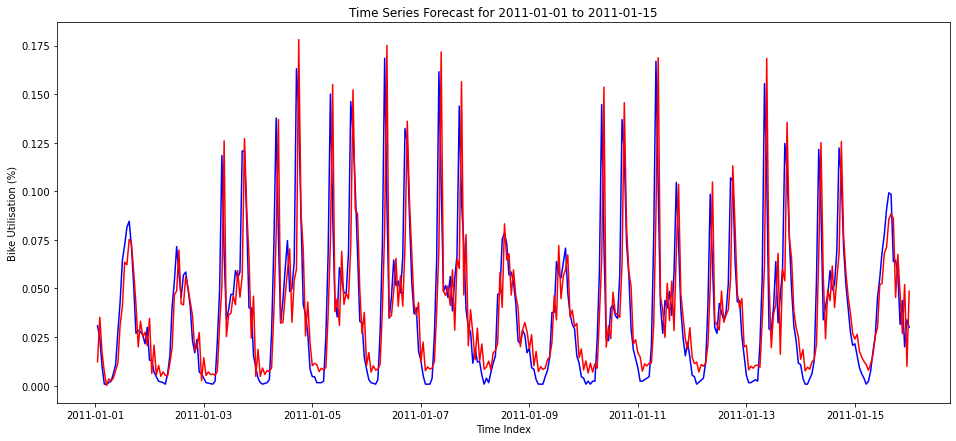

In [110]:
# Visualise first 15 days data
plt.figure(figsize = (16, 7))
plt.plot(arima_results['bike_utilisation'][:360], color = 'blue')
plt.plot(arima_results['forecast_utilisation'][:360], color = 'red')
plt.xlabel('Time Index')
plt.ylabel('Bike Utilisation (%)')
plt.title('Time Series Forecast for 2011-01-01 to 2011-01-15')
plt.show()

### Out-of-sample Performance Analysis <a class="anchor" id="section4_2_2"></a>

In [111]:
# Forecast fitted model against test set
# 7 periods ahead available only
y_out = model.predict(y_test.index[0], y_test.index[6])

In [112]:
# Combine y_test and y_out together
test_results = pd.concat([y_test[0:7], y_out.rename('forecast_utilisation')], axis = 1)
test_results

,bike_utilisation,forecast_utilisation
2012-12-29 00:00:00,0.020000,0.019461
2012-12-29 01:00:00,0.028462,0.017994
2012-12-29 02:00:00,0.014615,0.012388
2012-12-29 03:00:00,0.004615,0.008530
2012-12-29 04:00:00,0.002308,0.005873
2012-12-29 05:00:00,0.002308,0.004045
2012-12-29 06:00:00,0.005385,0.002786


In [113]:
# Compute Out-of-sample R2 score and RMSE for ARIMA model
R2_arima = r2_score(y_test[0:7], y_out)
RMSE_arima = (mean_squared_error(y_test[0:7], y_out))**0.5

print('Out-of-sample R2 for ARIMA:', R2_arima)
print('Out-of-sample RMSE (%) for ARIMA:', RMSE_arima)

Out-of-sample R2 for ARIMA: 0.7547314621733712
Out-of-sample RMSE (%) for ARIMA: 0.004669575860923891
